In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

import re

import nltk
from nltk.corpus import stopwords
stopwordsList=stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,roc_auc_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Data Preparation
********

    -Reading the text documents.
    -Preparing the dataframe.

In [2]:
# Step 1: get a list of all txt files in target directory for a particular category
tags=[r'\business',r'\entertainment',r'\politics',r'\sport',r'\tech']
length=[0,0,0,0,0]
filesList=[]
text=[]
for i in range(0,5):
    my_dir = r"C:\Users\inbox\OneDrive\Documents\bbc"
    os.chdir(my_dir+tags[i])
# Step 2: Build up list of files:
    for files in glob.glob("*.txt"):
        fileName, fileExtension = os.path.splitext(files)
        filesList.append(files) #filename with extension  
        length[i]+=1    
    for j in range(len(filesList)-length[i],len(filesList)):
            file1 = open(filesList[j])
            text.append(file1.read())              

In [3]:
#Preparing the final dataframe
labelMarker=[]
labelMarker.append(length[0])
labelMarker.append(length[0]+length[1])
labelMarker.append(length[0]+length[1]+length[2])
labelMarker.append(length[0]+length[1]+length[2]+length[3])
labelMarker.append(length[0]+length[1]+length[2]+length[3]+length[4])
# labelMarker has been updated to assign the labels correctly
df=pd.DataFrame()
labels=[]
ids=[]
for i in range(0,len(text)):
    ids.append("T"+str(i+1))
    if i<labelMarker[0]:
        labels.append("Business")
    elif i>=labelMarker[0] and i<labelMarker[1]:
        labels.append("Entertainment")
    elif i>=labelMarker[1] and i<labelMarker[2]:
        labels.append("Politics")
    elif i>=labelMarker[2] and i<labelMarker[3]:
        labels.append("Sports")
    else:
        labels.append("Technology")
df['DocumentID']=ids
df['Text']=text
df['Labels']=labels
df.head()

,DocumentID,Text,Labels
0,T1,Ad sales boost Time Warner profit\n\nQuarterly...,Business
1,T2,Dollar gains on Greenspan speech\n\nThe dollar...,Business
2,T3,Yukos unit buyer faces loan claim\n\nThe owner...,Business
3,T4,High fuel prices hit BA's profits\n\nBritish A...,Business
4,T5,Pernod takeover talk lifts Domecq\n\nShares in...,Business


# Data Exploration
********

    -Checking for null columns.
    -Checking for column with empty strings.
    -Stripping white spaces at beginning and end from the label names.
    -Distribution of various categories.

In [4]:
print("Total number of records is {}".format(df.shape[0]))

Total number of records is 2225




- No column has null values

In [5]:
#No column has null values
df.isnull().any()

DocumentID    False
Text          False
Labels        False
dtype: bool

- Distribution of the label.

In [6]:
df['Labels'].value_counts()

Sports           511
Business         510
Politics         417
Technology       401
Entertainment    386
Name: Labels, dtype: int64

********
<strong>Distribution Analysis</strong>

    - Category with very less data points will be considered as noise by model but there are no such categories in our data. 

# Data Preprocessing
***********

    -Helper functions
    -Data preprocessing using these functions
    -Distribution of Length of text documents for a optimal selection of max length while building a model.

In [7]:
# Removing anything followed by a @
def remove_mention(x):
    return re.sub(r'@[A-Za-z0-9]+','',x)

# Removing the urls
def remove_urls(x):
    return re.sub('https?://[A-Za-z0-9./]+','',x)

# Removing the Numbers
def remove_hastagNumbers(x):
    return re.sub("[^a-zA-Z]", " ", x)

# Split text at CamelCase
def split_uppercase(x):
    return str(" ".join([" ".join(re.split("([A-Z]{1}[a-z]+)",word)) for word in x.split(' ')]))
    
# Converting text in lowercase
def LowerCase(x):
    return str(x.lower())

# Removing stopwords
def StopwordsRemoval(x):
    return str(' '.join([each if each not in stopwordsList else '' for each in x.split(' ')]))

# Removing multiple white spaces from the text
def RemoveMultipleWhiteSpaces(x):
    FILTER_MULTIPLE_WHITESPACES = "\s\s+"
    return re.sub(FILTER_MULTIPLE_WHITESPACES,' ',x)

# Strip spaces at the end and the starting
def toStripWhiteSpaces(x):
    return x.strip()

# To remove new line characters from our text
def toStripNewLines(x):
    return x.rstrip('\r\n')

# Function for calling all the other functions
def preprocess(x):
    return toStripNewLines(toStripWhiteSpaces(RemoveMultipleWhiteSpaces(StopwordsRemoval(LowerCase(split_uppercase(remove_hastagNumbers(remove_urls(remove_mention(x)))))))))


- Helper Functions for data processing

In [8]:
#Preprocessing the text by using helper functions
df['preprocessed_description']=df['Text'].apply(preprocess)

- Processing text with the above defined helper functions

************************
<strong>Tokenization</strong>

In [9]:
# defining a function for word tokenizer
def tokenization(words):
    return(word_tokenize(words))

In [10]:
#Applying the above defined tokenization function
df['preprocessed_description']=df['preprocessed_description'].apply(tokenization)

***
<strong>Stemming</strong>

In [11]:
# defining a function for stemming
def stemming(words):
    porter = PorterStemmer()
    for i,word in enumerate(words):
        words[i]=porter.stem(word)
    return words   


In [12]:
#Applying the above defined stemming function 
df['preprocessed_description']=df['preprocessed_description'].apply(stemming)

***
<strong>Lemmatization</strong>

In [13]:
# defining a function for lemmatization
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    for i,word in enumerate(words):
        words[i]=lemmatizer.lemmatize(word)
    return words

In [14]:
#Applying the above defined lemmatization function 
df['preprocessed_description']=df['preprocessed_description'].apply(lemmatization)

In [15]:
df['preprocessed_description']

0       [ad, sale, boost, time, warner, profit, quarte...
1       [dollar, gain, greenspan, speech, dollar, hit,...
2       [yuko, unit, buyer, face, loan, claim, owner, ...
3       [high, fuel, price, hit, ba, profit, british, ...
4       [pernod, takeov, talk, lift, domecq, share, uk...
5       [japan, narrowli, escap, recess, japan, econom...
6       [job, growth, still, slow, u, u, creat, fewer,...
7       [india, call, fair, trade, rule, india, attend...
8       [ethiopia, crop, product, ethiopia, produc, mi...
9       [court, reject, bn, tobacco, case, u, govern, ...
10      [ask, jeev, tip, onlin, ad, reviv, ask, jeev, ...
11      [indonesian, face, fuel, price, rise, indonesi...
12      [peugeot, deal, boost, mitsubishi, struggl, ja...
13      [telegraph, newspap, axe, job, daili, sunday, ...
14      [air, passeng, win, new, eu, right, air, passe...
15      [china, keep, tight, rein, credit, china, effo...
16      [parmalat, boast, doubl, profit, parmalat, ita...
17      [india

# Word Vectorization

*************
<strong>Feature Engineering</strong>
    
    - Tranforming the data into features using tf-idf.

In [16]:
# Function for calculating the term frequency for each word in a document
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

In [17]:
# Function for calculating the inverse document frequency
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [18]:
# Function for calculating the tfidf
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [19]:
# Preparing the wordset containing all the words in the corpus
wordSet=set()
for bow in df['preprocessed_description']:
    wordSet=wordSet|set(bow)    

In [20]:
len(wordSet)

18839

In [21]:
# Preparing a list of dictionary having a word in a document as key and its count as the value
wordDictList=[]
for bow in df['preprocessed_description']:
    wordDict = dict.fromkeys(wordSet, 0) 
    for word in bow:
        wordDict[word]+=1
    wordDictList.append(wordDict)    

In [22]:
# Preparing a list of term frequency for the documents
tflist=[]
for i,bow in enumerate(df['preprocessed_description']):
    tfDict=computeTF(wordDictList[i], bow)
    tflist.append(tfDict)

In [23]:
len(tflist)

2225

In [24]:
# Calculation of the inverse document frequency
idfs = computeIDF(wordDictList)

In [25]:
# Preparing a list of tfidf for the documents or preprocessed description
tfIdfList=[]
for i,tf in enumerate(tflist):
    tfidf = computeTFIDF(tflist[i], idfs)
    tfIdfList.append(tfidf)

In [26]:
# Preparing a dataframe for the above calculated tfidf
df_tf_idf=pd.DataFrame(tfIdfList)

In [27]:
df_tf_idf.head(5)

,aa,aaa,aac,aadc,aaliyah,aaltra,aamir,aan,aara,aarhu,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*************
<strong>Encoding</strong>
    
    - Label encoding the target variable

In [28]:
#Label encode the target variable
finalDf=df
Encoder = LabelEncoder()
finalDf['encoded_labels'] = Encoder.fit_transform(finalDf['Labels'])

In [29]:
finalDf.head(5)

,DocumentID,Text,Labels,preprocessed_description,encoded_labels
0,T1,Ad sales boost Time Warner profit\n\nQuarterly...,Business,"[ad, sale, boost, time, warner, profit, quarte...",0
1,T2,Dollar gains on Greenspan speech\n\nThe dollar...,Business,"[dollar, gain, greenspan, speech, dollar, hit,...",0
2,T3,Yukos unit buyer faces loan claim\n\nThe owner...,Business,"[yuko, unit, buyer, face, loan, claim, owner, ...",0
3,T4,High fuel prices hit BA's profits\n\nBritish A...,Business,"[high, fuel, price, hit, ba, profit, british, ...",0
4,T5,Pernod takeover talk lifts Domecq\n\nShares in...,Business,"[pernod, takeov, talk, lift, domecq, share, uk...",0


# Data Splitting

    - Splitting the data in train test sample.
    - Using stratified sampling to check the accuracy for each Department label.

In [30]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(df_tf_idf,finalDf['encoded_labels'].values,test_size=0.2,random_state=0,stratify=finalDf['encoded_labels'].values)

# Model Training

***********************
<strong>Building a Logistic Regresion model</strong>

In [43]:
from sklearn import datasets, linear_model, metrics
clf = linear_model.LogisticRegression(random_state=0,solver='sag',multi_class='multinomial') 
clf.fit(Xtrain, ytrain) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

- Random state has been set to produce reproducible results

*************************
<strong>Evaluating the model</strong>

In [46]:
# Use accuracy_score function to get the accuracy
y_predicted_test=clf.predict(Xtest)
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_predicted_test, ytest)*100)

Logistic Regression Accuracy Score ->  66.51685393258427


In [45]:
#Classification report
print(classification_report(ytest, y_predicted_test, target_names=Encoder.classes_))

               precision    recall  f1-score   support

     Business       0.56      1.00      0.72       102
Entertainment       0.96      0.32      0.49        77
     Politics       1.00      0.44      0.61        84
       Sports       0.60      1.00      0.75       102
   Technology       1.00      0.38      0.55        80

     accuracy                           0.67       445
    macro avg       0.82      0.63      0.62       445
 weighted avg       0.80      0.67      0.63       445



***********************
<strong>Using Random Forest Classification</strong>

In [81]:
from sklearn.ensemble import RandomForestClassifier
#Creating a Random forest object with a random state for reproducible results
clf = RandomForestClassifier(max_depth=25,n_estimators=19, random_state=0)
#Training the model on train data
clf.fit(Xtrain, ytrain)
y_predicted_test = clf.predict(Xtest)

- Best accuracy is obtained at n_estimators=19 and max_depth=25

*************************
<strong>Evaluating the model</strong> 

In [82]:
# Use accuracy_score function to get the accuracy
print("Random Forest Accuracy Score -> ",accuracy_score(y_predicted_test, ytest)*100)

Random Forest Accuracy Score ->  96.17977528089887


In [83]:
#Classification report
print(classification_report(ytest, y_predicted_test, target_names=Encoder.classes_))

               precision    recall  f1-score   support

     Business       0.97      0.90      0.93       102
Entertainment       0.99      0.99      0.99        77
     Politics       0.92      0.95      0.94        84
       Sports       0.99      1.00      1.00       102
   Technology       0.94      0.97      0.96        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



***********************
<strong>Using KNN Classification</strong>

In [37]:
# Using K fold cross validation to find the optimum value of k
knn = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn, Xtrain, ytrain, cv=5, scoring='accuracy')

In [38]:
print(scores)

[0.67877095 0.60504202 0.57142857 0.57746479 0.58923513]


In [39]:
print(scores.mean())

0.6043882908334224


- This is the mean cross validation score for k=5

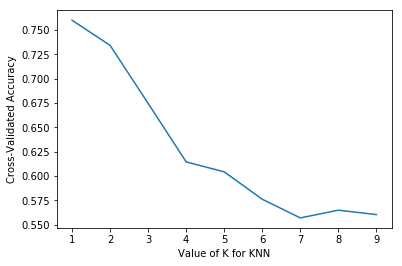

In [40]:
%matplotlib inline
# choose k between 1 to 10
k_range = range(1, 10)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xtrain, ytrain, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

- This plot shows that best accuracy will be obtained at k=1(i.e the boundaries between classes are very clear)

In [41]:
# fit the training dataset on the KNN classifier
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(Xtrain, ytrain)
# predict the labels on validation dataset
y_predicted_test = classifier.predict(Xtest)

*************************
<strong>Evaluating the model</strong>

In [42]:
# Use accuracy_score function to get the accuracy
print("KNN Accuracy Score -> ",accuracy_score(y_predicted_test, ytest)*100)

KNN Accuracy Score ->  76.85393258426966


In [43]:
#Classification report
print(classification_report(ytest, y_predicted_test, target_names=Encoder.classes_))

               precision    recall  f1-score   support

     Business       0.90      0.56      0.69       102
Entertainment       0.89      0.84      0.87        77
     Politics       0.58      0.95      0.72        84
       Sports       1.00      0.74      0.85       102
   Technology       0.68      0.81      0.74        80

     accuracy                           0.77       445
    macro avg       0.81      0.78      0.77       445
 weighted avg       0.82      0.77      0.77       445



***********************
************************
# CONCLUSION

## <strong>The three model approaches</strong>
    
  <i>Random Forest Model</i><br>

<strong>Pros</strong><br>
- As the data is less this model will outperform all the other models providing a accuracy of <strong>96.17%</strong>.
- The predictive performance can compete with the best supervised learning algorithms.<br>

<strong>Cons</strong><br> 
- An ensemble model is inherently less interpretable than an individual decision tree.
- Training a large number of deep trees can have high computational costs (but can be parallelized) and use a lot of memory.<br><br>
 
 
<i>Logistic Regression</i><br>

<strong>Pros</strong><br>
- It is easy to understand and it can also be trained on small dataset. <br>

<strong>Cons</strong><br> 
- The model is highly scalable although it is giving a accuracy of just <strong>66.51%</strong><br><br>


<i>KNN Classification</i><br>

<strong>Pros</strong><br>
- Simple algorithm — to explain and understand/interpret. <br>
- High accuracy (relatively) — it is pretty high but not competitive in comparison to better supervised learning models.It is  providing a accuracy of <strong>76.85%</strong> . 

<strong>Cons</strong><br> 
- Computationally expensive — because the algorithm stores all of the training data so it takes a lot of time to predict(not train).


*****************
## Challenges and Future Works

- The regular expression approach for replacing specific keywords may not work as the data will increase, the cleaning will take more time and regex is not that much scalable. Even for 1 million records it will take days to process it and if it fails we cannot track it properly.
- Preparation of the dataframe from the documents should be done properly to ensure no wrong labels.
- If the size of the dataset increases then tf-idf method for vectorization will fail because of large matrix size.
- Applying K-Fold Cross Validation on the data to find optimum value of K was computationally very intensive because of such large number of features.
- Model training can be improved by trying other approaches which are build majorly for text classification and response is fast with a probability of each class label.
- If the size increases and tf-idf starts to fail we can use tokenizer with CNN or Word Embedding with CNN.